---
title:  "혼자하는 Text분석_03"
excerpt: "Sckit-lean library 과 Keras를 사용한 Text 분석 비교"

categories:
  - Machine-Learning
tags:
  - KoNLPy
  - text anlysis
  - 머신러닝
  - linux docker
last_modified_at: 2020-03-21T16:13:00-05:00
---

## 이 분석은 개인적인 local 사정상, Docker 환경에서 실습했음을 알린다.  
### Docker 환경을 만든 이유는 local OS : Window 10 Home edition 이기 때문이다.  
 - docker toolbox 로 진행했는데, 꽤나 힘들었다.
KoNLPy 순서로 진행한다.

In [1]:
## 라이브러리 로드

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
# 시각화 결과가 선명하게 표시되도록
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [3]:
# Window 한글폰트 설정
# plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
plt.rc("font", family="AppleGothic")
plt.rc('axes', unicode_minus=False)

## Naver Movie Review 가져오기  
[이미 github 에 txt 파일로 정제된것을 활용했다.](https://github.com/e9t/nsmc)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer().fit(docs)
print(tfidfv.transform(docs).toarray())
print(tfidfv.vocabulary_)

[[0.         0.         0.         0.52640543 0.         0.66767854 0.52640543 0.         0.        ]
 [0.         0.         0.         0.57735027 0.57735027 0.         0.57735027 0.         0.        ]
 [0.         0.47212003 0.47212003 0.         0.7444497  0.         0.         0.         0.        ]
 [0.57735027 0.         0.         0.         0.         0.         0.         0.57735027 0.57735027]]
{'먹고': 3, '싶은': 6, '사과': 5, '바나나': 4, '길고': 1, '노란': 2, '저는': 7, '과일이': 0, '좋아요': 8}


TF_IDF 값이 다른 이유는 sckit-learn 에서는 수식이 약간 다르다. L2 정규화 Term 을 이용하기 때문이며,  
sckit-learn 의 수식은 Basic 01 을 참고하기를~

### BOW 의 발전 (n-gram)  
Bag Of Word 의 대표적인 단점은 단어의 순서가 무시된다는 점이 있다.  
이에, unigram(1개씩), bigram(2개씩), trigram(3개씩) 연속되는 단어를 묶어서, 표현하는 기법이 존재한다.  
예를 들어  ex> "it's bad, not good at all" vs "it's good, not bad at all" 의 표현은 기본 BOW (unigram 방식) 일때는 똑긑은 의미로 인식해버리기 때문이다.

In [97]:
bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [98]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [99]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("어휘 사전 크기: {}".format(len(cv.vocabulary_)))
print("어휘 사전:\n{}".format(cv.get_feature_names()))

어휘 사전 크기: 13
어휘 사전:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [100]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("어휘 사전 크기: {}".format(len(cv.vocabulary_)))
print("어휘 사전:\n{}".format(cv.get_feature_names()))

어휘 사전 크기: 14
어휘 사전:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [101]:
print("변환된 데이터 (밀집 배열):\n{}".format(cv.transform(bards_words).toarray()))

변환된 데이터 (밀집 배열):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [102]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("어휘 사전 크기: {}".format(len(cv.vocabulary_)))
print("어휘 사전:{}\n".format(cv.get_feature_names()))

어휘 사전 크기: 39
어휘 사전:['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']



In [106]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [107]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# 매개변수 조합이 많고 트라이그램이 포함되어 있기 때문에
# 그리드 서치 실행에 시간이 오래 걸립니다
param_grid = {'logisticregression__C': [0.001, 0.01],
              "tfidfvectorizer__ngram_range": [(1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=4)
grid.fit(text_train, y_train)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수:\n{}".format(grid.best_params_))

C:\ProgramData\Anaconda3\envs\test\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


최상의 크로스 밸리데이션 점수: 0.81
최적의 매개변수:
{'logisticregression__C': 0.01, 'tfidfvectorizer__ngram_range': (1, 3)}


In [108]:
# 그리드 서치에서 테스트 점수를 추출합니다
# scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
scores = grid.cv_results_['mean_test_score']

In [110]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logisticregression__C', 'param_tfidfvectorizer__ngram_range', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'mean_train_score', 'std_train_score'])

In [111]:
scores ## 0,1 부정 vs 긍정 에 대한 accu 값 확률

array([0.7986, 0.8084])

(-1, 1)

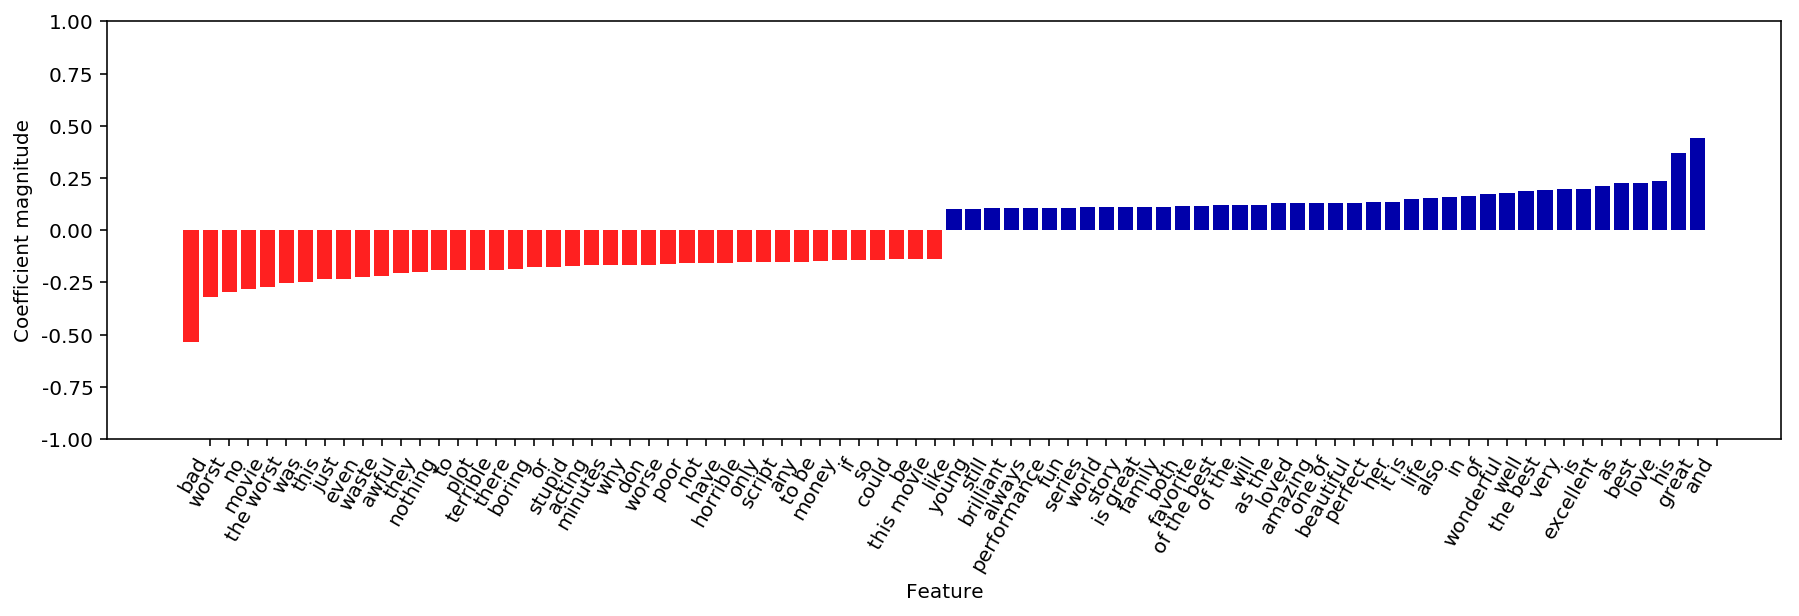

In [114]:
# 특성 이름과 계수를 추출합니다
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)
plt.ylim(-1, 1)

결과는 Basic 01 과 비슷하다. 

### 고급 토큰화, 어간 추출, 표제어 추출  
Spacy 영어 모듈을 다운로드 하려면 쉘에서 'python -m spacy.en.download all' 명령을 입력합니다.  
토큰화시, 지금까지 본것처럼, 단순히 단어 위주로 토큰화 하는 방법 외에, 좀더 고급진 여러 방법이 있다.  
- **어간(stem)** : 일일이 어미를 찾아서, 규칙기반으로 토큰화 하는 방법. 쉽게 얘기하면, 영어동사의 단수형, 복수형을 1개로 본다.  
- **표제어 추출(lemmatization)** : 단어의 알려진 형태사전을 미리 구축해놓고 이를 이용하는 방법 

In [125]:
# import spacy ## 표제어 추출
# en_nlp = spacy.load('en_core_web_sm') --> 대신 하기 en_nlp 직접 download

# spacy의 영어 모델을 로드합니다
import en_core_web_sm
en_nlp = en_core_web_sm.load()

In [126]:
import nltk ## 어간추출
import spacy ## 표제어 추출

# nltk의 PorterStemmer 객체를 만듭니다
stemmer = nltk.stem.PorterStemmer()

# spacy의 표제어 추출과 nltk의 어간 추출을 비교하는 함수입니다
def compare_normalization(doc):
    # spacy로 문서를 토큰화합니다
    doc_spacy = en_nlp(doc)
    # spacy로 찾은 표제어를 출력합니다
    print("표제어:")
    print([token.lemma_ for token in doc_spacy])
    # PorterStemmer로 찾은 토큰을 출력합니다
    print("어간:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [127]:
compare_normalization(u"Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")

표제어:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
어간:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


sckit-learn 에는 두 정규화 방법이 구현되어 있지않지만, 커스토마이징 해서, 사용가능하다.

In [135]:
# 요구사항: CountVectorizer의 정규식 기반 토큰 분할기를 사용하고
# spacy에서 표제어 추출 기능만 이용합니다.
# 이렇게하려고 en_nlp.tokenizer(spacy 토큰 분할기)를 
# 정규식 기반의 토큰 분할기로 바꿉니다
import re
# CountVectorizer에서 사용되는 정규식
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# spacy의 언어 모델을 로드하고 원본 토큰 분할기를 저장합니다
en_nlp =  en_core_web_sm.load()
old_tokenizer = en_nlp.tokenizer
# 정규식을 사용한 토큰 분할기를 바꿉니다
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# spacy 문서 처리 파이프라인을 사용해 자작 토큰 분할기를 만듭니다
# (우리만의 토큰 분할기를 사용합니다)
def custom_tokenizer(document):
#     doc_spacy = en_nlp(document, entity=False, parse=False)
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

In [136]:
# 자작 토큰 분할기를 사용해 CountVectorizer 객체를 만듭니다
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [138]:
# # 표제어 추출이 가능한 CountVectorizer 객체로 text_train을 변환합니다
# X_train_lemma = lemma_vect.fit_transform(text_train)
# print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# # 비교를 위해 표준 CountVectorizer를 사용합니다
# vect = CountVectorizer(min_df=5).fit(text_train)
# X_train = vect.transform(text_train)
# print("X_train.shape: {}".format(X_train.shape))

spacy import 에 문제가 있어서...일단...건너뛴다.

이 외에도, KoNLPy (형태소 분석기 = 한국어 전용 어간분석기) 를 사용할 수 있고, 실제로도 이를 많이 사용한다.  
그러나, 현재 실습 환경이 Window 인 관계로, 생략한다. 이는 추후 Collab 에서 활용하도록 한다  
"KoNLPy의 Mecab() 클래스는 윈도우에서 지원되지 않습니다." (http://konlpy.org/ko/latest/install/)